In [1]:
import pandas as pd
from typing import List
import torch
from torch.utils.data.dataloader import DataLoader, Dataset
import pytorch_lightning as pl
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
import mlflow
from mlflow import MlflowClient

/home/a/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Работаем над воспроизводимостью
torch.random.manual_seed(42)
import random
random.seed(42)
pl.seed_everything(42)

Seed set to 42


42

In [3]:
# Шаг 0. Создаем модель, с которой будем работать
# Step 0. Create the model, which we will be working with


# Шаг 0.1 Готовим класс датасета для лайтнинга
# Step 0.1 Preparing the Dataset class for Pytorch Lightning
from pytorch_lightning.core.module import LightningModule
from pytorch_lightning.trainer.trainer import Trainer


class TorchModelData(Dataset):
    def __init__(self, X: torch.Tensor, y: torch.Tensor):
        super().__init__()
        self.X = X
        self.y = y

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
    def __len__(self):
        return self.X.shape[0]
    


# Шаг 0.2 Описываем модель
class LightningModel(pl.LightningModule):
    def __init__(
            self,
            in_features: int,
            layer_neurons: List[int],
            activation_function_class,
            opt=torch.optim.NAdam,
            lr=0.01
    ):
        super().__init__()
        self._in_features = in_features
        self._layer_neurons = layer_neurons
        self._lr = lr
        self._opt = opt

        layers = []
        for i in range(len(layer_neurons)):
            if i == 0:
                input_neurons = in_features
            else:
                input_neurons = layer_neurons[i-1]
            
            layers.append(torch.nn.Linear(input_neurons, layer_neurons[i]))
            if i != (len(layer_neurons) - 1):
                layers.append(activation_function_class())
        
        self._model = torch.nn.Sequential(*layers)

    def forward(self, x):
        return self._model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        preds = self.forward(x)
        loss = torch.mean((y - preds)**2)
        self.log("train_mse", loss, prog_bar=True, on_epoch=True, on_step=False)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        preds = self.forward(x)
        loss = torch.mean((y - preds)**2)
        self.log("val_mse", loss, prog_bar=True, on_epoch=True, on_step=False)
        return loss
    
    def configure_optimizers(self):
        opt = self._opt(self.parameters(), lr=self._lr)
        return opt
    

# Шаг 0.3 - создаем обратный вызов pytorch lightning, где будем фиксировать метрики по эпохам
# для MLFlow

class MlflowMetricCallback(pl.Callback):
    def __init__(self, train_tensor, val_tensor, y_train, y_val):
        super().__init__()
        self._train_X = train_tensor
        self._val_X = val_tensor
        self._y_train = y_train.detach().cpu().numpy()
        self._y_val = y_val.detach().cpu().numpy()

    def on_train_epoch_end(self, trainer: Trainer, pl_module: LightningModule):
        preds_train = pl_module(self._train_X).detach().cpu().numpy()
        preds_val = pl_module(self._val_X).detach().cpu().numpy()

        epoch = trainer.current_epoch

        metrics = {
            "Train MAE": mean_absolute_error(self._y_train, preds_train),
            "Train R2": r2_score(self._y_train, preds_train),
            "Eval MAE": mean_absolute_error(self._y_val, preds_val),
            "Eval R2": r2_score(self._y_val, preds_val)
        }

        mlflow.log_metrics(metrics, step=epoch)

In [4]:
# Шаг 1. Загружаем данные
data = pd.read_excel("Concrete_Data.xls")
data

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075
...,...,...,...,...,...,...,...,...,...
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.284354
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.178794
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.696601
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.768036


In [5]:
target_name = "Concrete compressive strength(MPa, megapascals) "

In [6]:
# Шаг 2. Разбиваем данные на тренировку и валидацию

X_train, X_val = train_test_split(data, test_size=0.2, shuffle=True, random_state=42)
y_train, y_val = X_train.pop(target_name), X_val.pop(target_name)

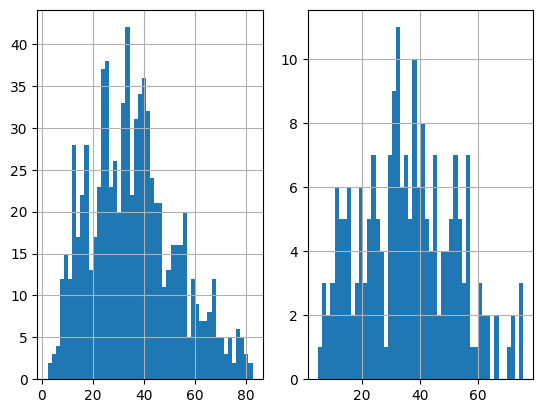

In [7]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=1, ncols=2)
y_train.hist(bins=50, ax=axs[0])
y_val.hist(bins=50, ax=axs[1])
plt.show()

In [8]:
# Трансформируем данные
from sklearn.preprocessing import RobustScaler

sc = RobustScaler()
sc.fit(X_train)

train_tensor = sc.transform(X_train)
train_tensor = torch.as_tensor(train_tensor, dtype=torch.float32)

val_tensor = sc.transform(X_val)
val_tensor = torch.as_tensor(val_tensor, dtype=torch.float32)

y_train_tensor = torch.as_tensor(y_train.to_numpy(), dtype=torch.float32)
y_val_tensor = torch.as_tensor(y_val.to_numpy(), dtype=torch.float32)

In [9]:
# Создаем загрузчики данных
train_ds = TorchModelData(train_tensor, y_train_tensor)
val_ds = TorchModelData(val_tensor, y_val_tensor)

train_dataloader = DataLoader(train_ds, batch_size=256)
val_dataloader = DataLoader(val_ds, batch_size=256)

In [10]:
# Обучаем тестовую модель
model = LightningModel(
    train_tensor.shape[1],
    [2, 1],
    torch.nn.ReLU
)

trainer = pl.Trainer(max_epochs=5, accelerator='cpu')
trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/a/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name   | Type       | Params
--------------------------------------
0 | _model | Sequential | 21    
--------------------------------------
21        Trainable params
0         Non-trainable params
21        Total params
0.000     Total estimated model params size (MB)


/home/a/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
/home/a/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
/home/a/.local/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 4: 100%|██████████| 4/4 [00:00<00:00, 157.24it/s, v_num=42, val_mse=1.52e+3, train_mse=1.57e+3]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 4/4 [00:00<00:00, 135.89it/s, v_num=42, val_mse=1.52e+3, train_mse=1.57e+3]


In [11]:
# Обучение прошло успешно, подключаем MLFLow
# Сначала запустим локальный сервер
# Для этого в терминале:
# mlflow server --host 127.0.0.1 --port 8080

# Далее, при включенном сервере:

client = MlflowClient(tracking_uri="http://127.0.0.1:8080")

all_experiments = client.search_experiments()
print(all_experiments)

[<Experiment: artifact_location='mlflow-artifacts:/735113632342717487', creation_time=1715598420516, experiment_id='735113632342717487', last_update_time=1715598420516, lifecycle_stage='active', name='Concrete_Models', tags={'mlflow.note.content': 'Experiment on forecasting concrete strength',
 'project_name': 'concrete-strength'}>, <Experiment: artifact_location='mlflow-artifacts:/0', creation_time=1715594875056, experiment_id='0', last_update_time=1715594875056, lifecycle_stage='active', name='Default', tags={}>]


In [12]:
# Создаем эксперимент, если его еще нет
concrete_experiment = client.search_experiments(
    filter_string="tags.`project_name` = 'concrete-strength'"
)

if len(concrete_experiment) == 0:
    experiment_description = (
        "Experiment on forecasting concrete strength"
    )

    # Добавляем теги
    experiment_tags = {
        "project_name": "concrete-strength",
        "mlflow.note.content": experiment_description,
    }

    # Создаем эксперимент, даем ему уникальное имя
    concrete_experiment = client.create_experiment(
        name="Concrete_Models", tags=experiment_tags
    )

In [13]:
# Обучаем нормальный бейзлайн, логируем параметры

mlflow.set_tracking_uri("http://127.0.0.1:8080")
experiment = mlflow.set_experiment("Concrete_Models")

run_name = "Baseline Model"
artifact_path = "BaselineModel"

with mlflow.start_run(run_name=run_name) as run:
    model_params = {
        "in_features": train_tensor.shape[1],
        "layer_neurons": [4, 1],
        "activation_function_class": torch.nn.ReLU
    }

    # Обучаем тестовую модель
    model = LightningModel(**model_params)

    mlflow_callback = MlflowMetricCallback(train_tensor, val_tensor, y_train_tensor, y_val_tensor)

    trainer = pl.Trainer(max_epochs=15, accelerator='cpu', callbacks=[mlflow_callback])
    trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

    model.eval()
    preds = model(val_tensor)

    detached_real = y_val_tensor.detach().cpu().numpy()
    detached_pred = preds.detach().cpu().numpy()

    metrics = {
        "Final Eval MAE": mean_absolute_error(detached_real, detached_pred),
        "Final Eval R2": r2_score(detached_real, detached_pred)
    }

    # Запишем данные по эксперименту в MLFlow
 
    mlflow.log_params(model_params)
    mlflow.log_metrics(metrics)
    mlflow.pytorch.log_model(model, artifact_path)

mlflow.end_run()

print(metrics)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/a/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name   | Type       | Params
--------------------------------------
0 | _model | Sequential | 41    
--------------------------------------
41        Trainable params
0         Non-trainable params
41        Total params
0.000     Total estimated model params size (MB)


/home/a/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
/home/a/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
/home/a/.local/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 4: 100%|██████████| 4/4 [00:00<00:00, 101.50it/s, v_num=43, val_mse=1.49e+3, train_mse=1.55e+3]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 4/4 [00:00<00:00, 89.18it/s, v_num=43, val_mse=1.49e+3, train_mse=1.55e+3] 
{'Final Eval MAE': 35.15579, 'Final Eval R2': -4.780042539483034}


/usr/local/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [14]:
# Гипотеза 1: Неподходящий оптимизатор: попробуем SGD
run_name = "SGD Model"
artifact_path = "SGDModel"

with mlflow.start_run(run_name=run_name) as run:
    model_params = {
        "in_features": train_tensor.shape[1],
        "layer_neurons": [4, 1],
        "activation_function_class": torch.nn.ReLU,
        "opt": torch.optim.SGD,
        "lr": 0.01
    }

    # Обучаем тестовую модель
    model = LightningModel(**model_params)

    mlflow_callback = MlflowMetricCallback(train_tensor, val_tensor, y_train_tensor, y_val_tensor)

    trainer = pl.Trainer(max_epochs=15, accelerator='cpu', callbacks=[mlflow_callback])
    trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

    model.eval()
    preds = model(val_tensor)

    detached_real = y_val_tensor.detach().cpu().numpy()
    detached_pred = preds.detach().cpu().numpy()

    metrics = {
        "Final Eval MAE": mean_absolute_error(detached_real, detached_pred),
        "Final Eval R2": r2_score(detached_real, detached_pred)
    }

    # Запишем данные по эксперименту в MLFlow
 
    mlflow.log_params(model_params)
    mlflow.log_metrics(metrics)
    mlflow.pytorch.log_model(model, artifact_path)

mlflow.end_run()

print(metrics)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/a/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name   | Type       | Params
--------------------------------------
0 | _model | Sequential | 41    
--------------------------------------
41        Trainable params
0         Non-trainable params
41        Total params
0.000     Total estimated model params size (MB)


/home/a/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
/home/a/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
/home/a/.local/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 4: 100%|██████████| 4/4 [00:00<00:00, 99.42it/s, v_num=44, val_mse=278.0, train_mse=298.0]     

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 4/4 [00:00<00:00, 90.10it/s, v_num=44, val_mse=278.0, train_mse=298.0]
{'Final Eval MAE': 12.709404, 'Final Eval R2': 0.07033993794851057}


In [15]:
# Гипотеза 2: слишком мало нейронов. Попробуем увеличить

run_name = "More Neurons Model"
artifact_path = "ManyNeuronsModel"

with mlflow.start_run(run_name=run_name) as run:
    model_params = {
        "in_features": train_tensor.shape[1],
        "layer_neurons": [32, 16, 1],
        "activation_function_class": torch.nn.ReLU,
        "lr": 0.01
    }

    # Обучаем тестовую модель
    model = LightningModel(**model_params)

    mlflow_callback = MlflowMetricCallback(train_tensor, val_tensor, y_train_tensor, y_val_tensor)

    trainer = pl.Trainer(max_epochs=15, accelerator='cpu', callbacks=[mlflow_callback])
    trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

    model.eval()
    preds = model(val_tensor)

    detached_real = y_val_tensor.detach().cpu().numpy()
    detached_pred = preds.detach().cpu().numpy()

    metrics = {
        "Final Eval MAE": mean_absolute_error(detached_real, detached_pred),
        "Final Eval R2": r2_score(detached_real, detached_pred)
    }

    # Запишем данные по эксперименту в MLFlow
 
    mlflow.log_params(model_params)
    mlflow.log_metrics(metrics)
    mlflow.pytorch.log_model(model, artifact_path)

mlflow.end_run()

print(metrics)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/a/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name   | Type       | Params
--------------------------------------
0 | _model | Sequential | 833   
--------------------------------------
833       Trainable params
0         Non-trainable params
833       Total params
0.003     Total estimated model params size (MB)


/home/a/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
/home/a/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
/home/a/.local/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 4: 100%|██████████| 4/4 [00:00<00:00, 79.77it/s, v_num=45, val_mse=735.0, train_mse=1.01e+3]   

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 4/4 [00:00<00:00, 71.65it/s, v_num=45, val_mse=735.0, train_mse=1.01e+3]
{'Final Eval MAE': 21.068789, 'Final Eval R2': -1.4267559497231592}


In [16]:
# Гипотеза 3: недостаточно гибкая функция активации. Попробуем GELU + добавим эпох обучения

run_name = "Many Neurons, GELU, more train time"
artifact_path = "NeuronsGeluTrainTime"

with mlflow.start_run(run_name=run_name) as run:
    model_params = {
        "in_features": train_tensor.shape[1],
        "layer_neurons": [12, 1],
        "activation_function_class": torch.nn.GELU,
        "lr": 0.01
    }

    # Обучаем тестовую модель
    model = LightningModel(**model_params)

    mlflow_callback = MlflowMetricCallback(train_tensor, val_tensor, y_train_tensor, y_val_tensor)

    trainer = pl.Trainer(max_epochs=25, accelerator='cpu', callbacks=[mlflow_callback])
    trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

    model.eval()
    preds = model(val_tensor)

    detached_real = y_val_tensor.detach().cpu().numpy()
    detached_pred = preds.detach().cpu().numpy()

    metrics = {
        "Final Eval MAE": mean_absolute_error(detached_real, detached_pred),
        "Final Eval R2": r2_score(detached_real, detached_pred)
    }

    # Запишем данные по эксперименту в MLFlow
 
    mlflow.log_params(model_params)
    mlflow.log_metrics(metrics)
    mlflow.pytorch.log_model(model, artifact_path)

mlflow.end_run()

print(metrics)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/a/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name   | Type       | Params
--------------------------------------
0 | _model | Sequential | 121   
--------------------------------------
121       Trainable params
0         Non-trainable params
121       Total params
0.000     Total estimated model params size (MB)


/home/a/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
/home/a/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
/home/a/.local/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 9: 100%|██████████| 4/4 [00:00<00:00, 94.19it/s, v_num=46, val_mse=1.14e+3, train_mse=1.22e+3] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 4/4 [00:00<00:00, 84.36it/s, v_num=46, val_mse=1.14e+3, train_mse=1.22e+3]
{'Final Eval MAE': 29.293703, 'Final Eval R2': -3.287185736321133}
